# Multiclass Classification of Fatal Car Crashes
Authors:  Ned Kost, Ulises Gomez
Date:  August 25th, 2023

## Goal
Predict the contributing factor for a fatal car crash.  The contributing factor will fall into 3 categories: 
- drunk_driver_involved
- speeding_driver_involved
- other

## TODO
- Load Data into dataframe and clean it
- Identify features to use for the classifier model
- Find a classifier that will do multiclass and probabilty as output.  Preferrably with explainability
- Dockerize the output

In [323]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report


In [324]:
warnings.filterwarnings("ignore")

## Load and Clean Data

In [325]:
#Load data from Dataframe
df = pd.read_csv('../data/train/fars_train.csv', quoting=1, delimiter=',')
df.head()


,u_id,fatals,a_ct,a_ped_f,a_pedal_f,a_roll,a_hr,a_polpur,month,day,...,owner,deaths,numoccs,impact1,deformed,ve_forms,ve_total,weather,lgt_cond,driver_factor
0,32083,1,Single-Vehicle Crash,Other Crash,Other Crash,Other Crash,No - Hit and Run,Other Crash,10,2,...,Driver (in this crash) Was Registered Owner,1,1.0,Clockpoint 12,Disabling damage,1,1,Clear,Dark - not lighted,other
1,55073,1,Single-Vehicle Crash,Other Crash,Other Crash,Other Crash,No - Hit and Run,Other Crash,6,21,...,Driver (in this crash) Not Registered Owner (o...,1,1.0,Clockpoint 1,Disabling damage,1,1,Clear,Daylight,speeding_driver_involved
2,7458,1,Single-Vehicle Crash,Other Crash,Other Crash,Other Crash,No - Hit and Run,Other Crash,7,14,...,Driver (in this crash) Was Registered Owner,0,1.0,Clockpoint 12,NaN,1,1,Clear,Daylight,other
3,5685,1,Single-Vehicle Crash,Other Crash,Other Crash,Other Crash,No - Hit and Run,Other Crash,9,15,...,Driver (in this crash) Not Registered Owner (o...,0,1.0,Clockpoint 12,Functional damage,1,1,Clear,Dark - not lighted,other
4,9245,1,Single-Vehicle Crash,Other Crash,Other Crash,Other Crash,No - Hit and Run,Other Crash,9,28,...,Driver (in this crash) Was Registered Owner,1,1.0,Clockpoint 9,Disabling damage,1,1,Clear,Dark - not lighted,drunk_driver_involved


In [326]:
def binary_cat(row_value, zero_value):
    if(row_value == zero_value):
        return 0
    else:
        return 1
    

In [332]:
#Clean up Categorical Data
features = ['fatals', 'permvit', 'age', 'deaths', 'month', 'pernotmvit', 've_total']


cleaned_df = df[features]
#cleaned_df['numoccs'] = cleaned_df['numoccs'].fillna(0.0)

#Create columns for Binary Features
cleaned_df['is_ped_fatality'] = df['a_ped_f'].apply(lambda x: binary_cat(x, 'Other Crash'))
cleaned_df['is_weekend'] = df['a_dow_type'].apply(lambda x: binary_cat(x, 'Weekday'))
cleaned_df['is_night'] = df['a_tod_type'].apply(lambda x: binary_cat(x, 'Daytime'))
cleaned_df['is_urban'] = df['a_ru'].apply(lambda x: binary_cat(x, 'Rural'))
cleaned_df['is_inter'] = df['a_inter'].apply(lambda x: binary_cat(x, 'Non-Interstate'))
cleaned_df['is_intsec'] = df['a_intsec'].apply(lambda x: binary_cat(x, 'Non-Intersection'))
cleaned_df['on_roadway'] = df['a_relrd'].apply(lambda x: 1 if x.startswith('On') else 0)
cleaned_df['off_roadway'] = df['a_relrd'].apply(lambda x: 1 if x.startswith('Off') else 0)
cleaned_df['is_junc'] = df['a_junc'].apply(lambda x: 1 if str(x).startswith('Junct') else 0)
cleaned_df['not_junc'] = df['a_junc'].apply(lambda x: 1 if str(x).startswith('Non') else 0)
#cleaned_df['is_bike_fatality'] = df['a_ped_f'].apply(lambda x: binary_cat(x, 'Other Crash'))
#cleaned_df['is_rollover'] = df['a_roll'].apply(lambda x: binary_cat(x, 'Other Crash'))   #hurt multi-nomial output
cleaned_df['is_hit_and_run'] = df['a_hr'].apply(lambda x: binary_cat(x, 'No - Hit and Run'))  #no impact to multi-nomial
cleaned_df['is_police_pursuit'] = df['a_polpur'].apply(lambda x: binary_cat(x, 'Other Crash'))  
cleaned_df['is_ped'] = df['a_ped'].apply(lambda x: binary_cat(x, 'no'))  

#Create columns for non-Ordinal Features
label_encoder = LabelEncoder()     #Create Label Encoder

#cleaned_df['owner_reg'] = label_encoder.fit_transform(df['owner'])
#cleaned_df['impact_loc'] = label_encoder.fit_transform(df['impact1'])
#cleaned_df['weather_cond'] = label_encoder.fit_transform(df['weather'])
#cleaned_df['light_cond'] = label_encoder.fit_transform(df['lgt_cond'])


cleaned_df['body_type'] = df['a_body']
cleaned_df['owner_reg'] = df['owner']
cleaned_df['impact_loc'] = df['impact1']
cleaned_df['weather_cond'] = df['weather']
cleaned_df['light_cond'] = df['lgt_cond']

for col in cleaned_df.dtypes[cleaned_df.dtypes == 'object'].index:
    for_dummy = cleaned_df.pop(col)
    cleaned_df = pd.concat([cleaned_df, pd.get_dummies(for_dummy, prefix=col)], axis=1)


#Create column for Ordinal Features (treating as non-ordinal FOR NOW)
cleaned_df['road_type'] = label_encoder.fit_transform(df['a_roadfc'])
cleaned_df['deform_type'] = label_encoder.fit_transform(df['deformed'])
#cleaned_df['state_occ'] = label_encoder.fit_transform(df['state'])  #very minor neg impat to multi-nomial

cleaned_df.head()

,fatals,permvit,age,deaths,month,pernotmvit,ve_total,is_ped_fatality,is_weekend,is_night,...,light_cond_Dark - lighted,light_cond_Dark - not lighted,light_cond_Dark - unknown lighting,light_cond_Dawn,light_cond_Daylight,light_cond_Dusk,light_cond_Other,light_cond_Reported as unknown,road_type,deform_type
0,1,1,62,1,10,0,1,0,0,1,...,0,1,0,0,0,0,0,0,4,0
1,1,1,40,1,6,0,1,0,0,0,...,0,0,0,0,1,0,0,0,3,0
2,1,1,26,0,7,1,1,0,0,1,...,0,0,0,0,1,0,0,0,2,4
3,1,1,64,0,9,1,1,0,0,1,...,0,1,0,0,0,0,0,0,5,1
4,1,1,45,1,9,0,1,0,0,1,...,0,1,0,0,0,0,0,0,2,0


# Build Train and Test dataset

In [328]:
#Create Datasets to use in Models
X = cleaned_df
y = df['driver_factor']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=125)

## MultiNomial Naive Base Model

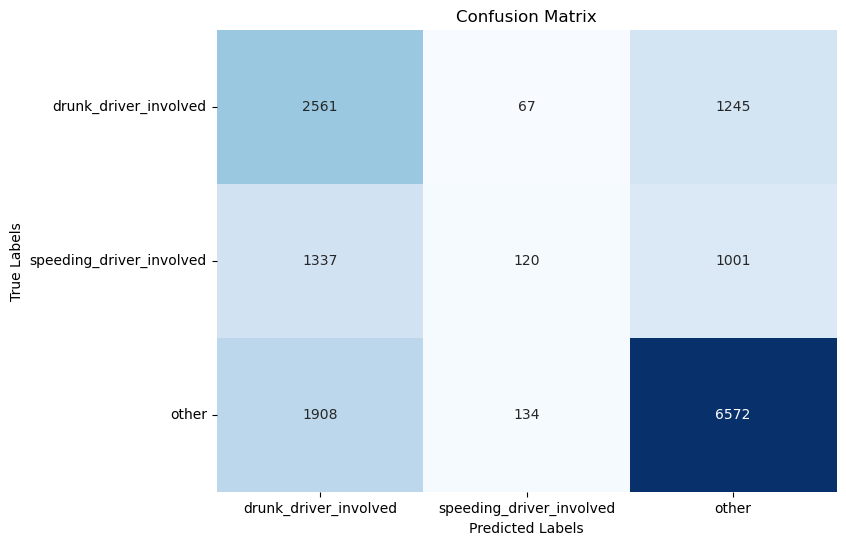

0.4565215012268693


In [330]:
#Multinomial Model
model = MultinomialNB()
model.fit(X,y)

predict = model.predict(X_test)

#Measure Output of MultiNomial Model
cat_lbl = ['drunk_driver_involved', 'speeding_driver_involved','other']
cm = confusion_matrix(y_test, predict, labels = cat_lbl )

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=cat_lbl,  yticklabels=cat_lbl)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

print(f1_score(y_test, predict, average='macro', labels=cat_lbl))
#0.5503871319938812

## Gradient Boosting Model

In [405]:
cat_lbl = ['drunk_driver_involved', 'speeding_driver_involved','other']

X = cleaned_df
y = label_encoder.fit_transform(df['driver_factor'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=500)

    
gb_model = XGBClassifier(n_estimators=190, max_depth=6, learning_rate=0.13465232824084064, random_state=42)
gb_model.fit(X_train,y_train)
gb_predict = gb_model.predict(X_test)

gb_predict_decoded = label_encoder.inverse_transform(gb_predict)
y_test_decoded = label_encoder.inverse_transform(y_test)

print(f1_score(y_test_decoded, gb_predict_decoded, average='macro', labels=cat_lbl))

#0.5643295354621035
#0.5646008114078727
#0.5647829374800492

0.5647829374800492


In [349]:
X = cleaned_df
y_oVn = df['driver_factor'].apply(lambda x: 1 if x=='other' else 0)

X_train, X_test, y_train, y_test = train_test_split(X, y_oVn, test_size=.30, random_state=500)


gb_model = XGBClassifier(n_estimators=100, learning_rate=.25, random_state=42)
gb_model.fit(X_train,y_train)
gb_predict = gb_model.predict(X_test)
    
gb_predict_decoded = label_encoder.inverse_transform(gb_predict)
y_test_decoded = label_encoder.inverse_transform(y_test)
print(f1_score(y_test_decoded, gb_predict_decoded, average='macro', labels=cat_lbl))




0.5053637037133512


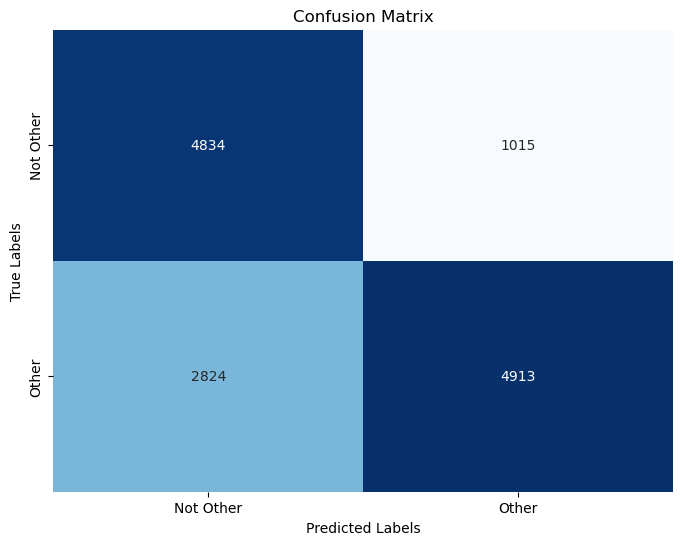

0.7174201524593325


In [390]:
#Take entire TEST Dataset and perform MultiNomialNB based on if it is OTHER or NOT-OTHER
X = cleaned_df
y_oVn = df['driver_factor'].apply(lambda x: 'Other' if x=='other' else 'Not Other')

X_train, X_test, y_train, y_test = train_test_split(X, y_oVn, test_size=.30, random_state=500)

#Multinomial Model
model = MultinomialNB()
model.fit(X_train, y_train)

predict = model.predict(X_test)

#Measure Output of MultiNomial Model
cat_lbl = ['Not Other', 'Other']
cm = confusion_matrix(y_test, predict, labels = cat_lbl )

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=cat_lbl,  yticklabels=cat_lbl)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

print(f1_score(y_test, predict, average='macro', labels=cat_lbl))
#0.5503871319938812


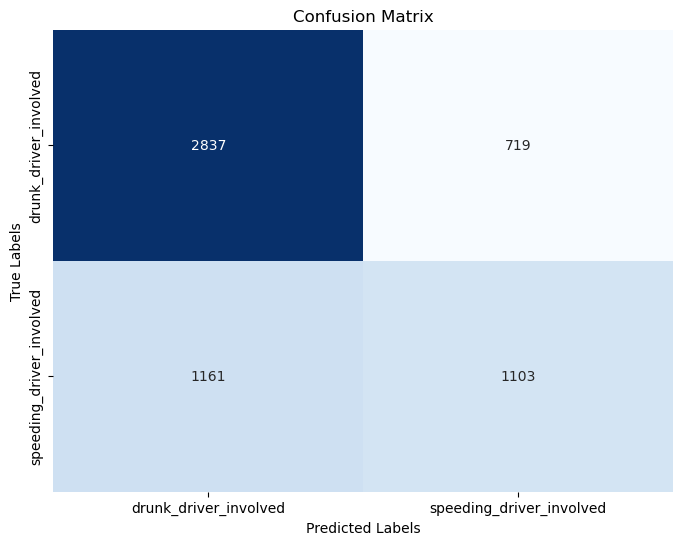

0.6455087734440272


In [389]:
#Filter cleaned_df to only be Drunk Driver or Speeding (i.e. NOT OTHER)
X_not_other = cleaned_df[cleaned_df.index.isin(df[df['driver_factor'] != 'other'].index)]  #X data (i.e. feature) only contains durnk or speeding
df_filtered = df[df['driver_factor'] != 'other']  
y_dvs = df_filtered['driver_factor']     #y Data (i.e. Labels) only contains Drunk or Speeding

X_train_dvs, X_test_dvs, y_train_dvs, y_test_dvs = train_test_split(X_not_other, y_dvs, test_size=.30, random_state=500)

#Multinomial Model
model_dvs = MultinomialNB()
model_dvs.fit(X_train_dvs, y_train_dvs)

predict_dvs = model_dvs.predict(X_test_dvs)

#Measure Output of MultiNomial Model
cat_lbl = ['drunk_driver_involved', 'speeding_driver_involved']
cm = confusion_matrix(y_test_dvs, predict_dvs, labels = cat_lbl )

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=cat_lbl,  yticklabels=cat_lbl)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

print(f1_score(y_test_dvs, predict_dvs, average='macro', labels=cat_lbl))


In [402]:
#Take X_Test data from first round prediction, filter out "OTHER", and do second round of prediction
X_test['Pred_1'] = predict
filtered_X_Test = X_test[X_test['Pred_1'] == 'Not Other']
dvs_test = filtered_X_Test.drop(columns='Pred_1')

#Put X_Test into model_DVS (i.e. Drunk vs. Speeding)
predict_2 = model_dvs.predict(dvs_test)

#Recombine with DVS_Test to get indexes for predictions
dvs_test['Predict_2'] = predict_2

## TODO:  Take DVS_Test and assemble with Precition_1 output for X_Test and build new F score reuslts.


7658 13586


### Step 1: Multinomial to predict Other or Not-Other

### Step 2: Anything predict as Not-Other goes through another Prediction
- Step 2a: Create additional Model for not-other (i.e. Drunk vs. Speeding)
- Step 2b: Predict for not-Other (i.e. Drunk vs Speeding)
    
### Step 3: Combine results of Step 1 and Step 2 to recalculate FScore